## Objectives: Exploratory Data Analysis (EDA) for Components' All the News 2.0 Dataset

The major challenge of this dataset is the size of the CSV file: 2.7M news articles and essays that comprise ~ 8 GB of data after the dataset is unzipped. The most memory intensive feature of the data is the 'article' column, where data is stored as a string. 

I was able to set up my machine to run PySpark after I installed a new Java runtime, Zulu. Apparently this Java runtime plays nicely with PySpark on Mac. I used the SDKMAN project to easily install the needed software. 

After initializing a Spark session, I was able to load the full dataset in less than six seconds! However, the shape of the data was an unexpected 3.8M rows/10 columns. I was expecting to see one row for each article, or 2.7M rows. A closer inspection of the data frame showed that some column data was being shifted to the right and dropping to form a new row.

I was able to make some improvements on the data loader by passing these arguments to `spark.read.csv`: 
```
df = spark.read.csv('./data/all-the-news-2-1.csv', header=True,  multiLine=True, mode="DROPMALFORMED", inferSchema=True)
```
This eliminated about 300K rows, but I no longer felt confident about the quality of the data. 

I then switched to Pandas as an alternative to Spark, though I know Pandas requires all data to be in memory for processing and visualization. 

I decided to use a couple of default parallel computing libraries: `multiprocessing` and `joblib` to reduce data processing time. 


### Load core libraries

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from joblib import Parallel, delayed
from tqdm.notebook import tqdm


### Get data from Components website (Data Lineage)

This is a large file! All files have been downloaded locally for purposes of EDA, but will not be uploaded to Github in order to stay within file size limits. Github blocks files larger than 100MB unless they are tracked in Git Large File Storage (Git LFS). Still, the max file size limit for GitHub Free is 2GB. More information can be found on the [GitHub Docs wesbite](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-git-large-file-storage).

From the [Components website](https://components.one/datasets/all-the-news-2-news-articles-dataset/):

This dataset contains 2,688,878 news articles and essays from 27 American publications, spanning January 1, 2016 to April 2, 2020. It is an expanded edition of the original All the News dataset on Kaggle, which was compiled in early 2017. While the original dataset contains more than 100,000 articles, the new dataset's greater size and breadth makes it more broadly applicable for both training language models and studying a wider selection of media.

Publications were scraped with Python according to the publications' sitemaps, with a few exceptions (like Vox) involving RSS feeds. The last day of scraping was on April 2, 2020.

In [ ]:
# Get data the data and unzip it

%%sh
wget https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip?dl=0
mv all-the-news-2-1.zip?dl=0 all-the-news-2-1.zip
unzip all-the-news-2-1.zip
ls -lh

In [1]:
"""
Check the file size of the full dataset. I have put the unzipped file into a 
folder called "data" in the same directory as this notebook. 
"""

print(f'File Size in Gigabytes: {os.path.getsize("./data/all-the-news-2-1.csv") / 1e9}')

File Size in Gigabytes: 8.761188341


The full CSV file is nearly 9GB. 

### Chunk files for initial inspection

In [2]:
# This code will create multiple csv files, at 500K rows each

SOURCE_PATH = "./data/all-the-news-2-1.csv"

for i, chunk in enumerate(pd.read_csv(SOURCE_PATH, chunksize=500000)):
    chunk.to_csv(f"./data/all-the-news-2-1-{i}.csv", index=False)

In [4]:
# Load the first CSV file and inspect the data

df_0 = pd.read_csv("./data/all-the-news-2-1-0.csv")
df_0.head(5)

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters
3,2019-06-27 00:00:00,2019,6.0,27,NaN,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,https://www.reuters.com/article/france-politic...,World News,Reuters
4,2016-01-27 00:00:00,2016,1.0,27,NaN,Paris Hilton: Woman In Black For Uncle Monty's...,Paris Hilton arrived at LAX Wednesday dressed ...,https://www.tmz.com/2016/01/27/paris-hilton-mo...,NaN,TMZ


In [5]:
df_0.shape

(500000, 10)

In [6]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         500000 non-null  object 
 1   year         500000 non-null  int64  
 2   month        500000 non-null  float64
 3   day          500000 non-null  int64  
 4   author       379206 non-null  object 
 5   title        500000 non-null  object 
 6   article      497385 non-null  object 
 7   url          500000 non-null  object 
 8   section      213313 non-null  object 
 9   publication  500000 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 38.1+ MB


The date is a non-datetime object, which we can convert to help with additonal temporal analysis. Also, we should convert the month to its actual label. 

There are multiple goals in the GLG Capstone project:
1. Named Entity Recognition for short text paragraphs geared towards identification of topics that imply technological or healthcare terms.
2. Unsupervised clustering of time-stamped topics.
3. Hierarchical clustering of topics or temporal sequence learning for identified topics.

Based on our Capstone goals, we can likely drop `author`, `title` and `url.` The remaining columns can likely support some aspect of our project. We can save these columns in a separate dataframe in case we need them in the future.


In [7]:
# Take a look at a single article

print(df_0['article'][121000])

LONDON (Reuters) - Doing things one at a time in drug development is not a luxury that GlaxoSmithKline can afford any longer, the head of pharmaceuticals at Britain’s largest drugmaker told Reuters.  Luke Miels, who joined GSK in September 2017 after a contract dispute with his former employer AstraZeneca, said picking the most promising projects and developing them quickly now takes precedence over spreading the risk of failure.  “In the past, 10 programs were chosen, a budget for eight was allocated. Usually what happened was that time was the trade off that was made,” he said in an interview.   “Now what we do is we pick five or six programs, and concentrate investment there.”   GSK, like rivals, was in the habit of testing new drugs first on patients who had run out of other treatment options. If successful, it would try patients at an earlier stage of their disease, replacing older, established treatments.   In today’s market, where rivals in the United States and China catch up f

GLG said in their project proposal that "effort(s) can be limited to mining a single paragraph of text from these articles only." It's not clear from this single example if extracting the first paragraph is possible, or if it even provides the value that GLG is expecting. News articles are typically written in one-sentence style paragraphs. It might be possible to capture multiple sentences or a number of characters instead.

In [8]:
#Check the new file size of the new csv

print(f'File Size in Gigabytes: {os.path.getsize("./data/all-the-news-2-1-0.csv") / 1e9}')

File Size in Gigabytes: 1.696574773


Chunking the original CSV file into six files of ~500K rows each makes it much less memory intensive to load and manipulate data for purposes of EDA. The first chunked CSV file comes in under 1.7GB. However, it would be great to load the full dataset to inspect the data all at once.

### Load full dataset

The [multiprocessing module](https://docs.python.org/3/library/multiprocessing.html) comes out-of-the-box with Python. The module provides process-based data parallelism. The API provids a simple means to increase our CPU for data processing.

In [9]:
# Create workers by doubling our CPU count

n_workers = 2 * mp.cpu_count()

In [10]:
# How many workers do we have?

print(f"{n_workers} workers are available")

20 workers are available


In [11]:
%%time

# Load the full dataset into a dataframe and output the time it takes to load

df = pd.read_csv("./data/all-the-news-2-1.csv", on_bad_lines='warn', low_memory=False)
df.head(5)

CPU times: user 1min 5s, sys: 2min 10s, total: 3min 15s
Wall time: 12min 48s


,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters
3,2019-06-27 00:00:00,2019,6.0,27,NaN,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,https://www.reuters.com/article/france-politic...,World News,Reuters
4,2016-01-27 00:00:00,2016,1.0,27,NaN,Paris Hilton: Woman In Black For Uncle Monty's...,Paris Hilton arrived at LAX Wednesday dressed ...,https://www.tmz.com/2016/01/27/paris-hilton-mo...,NaN,TMZ


The full data frame loads in about 13 minutes. Not blazingly fast by any means, but not bad if you're able to take a break for a cup of tea.

In [12]:
#Count the number of rows and columns in the dataframe

rows = len(df.axes[0])
cols = len(df.axes[1])

print(f'The dataset has {rows} rows and {cols} columns')

The dataset has 2688878 rows and 10 columns


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688878 entries, 0 to 2688877
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   year         int64  
 2   month        float64
 3   day          int64  
 4   author       object 
 5   title        object 
 6   article      object 
 7   url          object 
 8   section      object 
 9   publication  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 205.1+ MB


The full dataframe consumes about a quarter of a gigabyte's worth of memorty (205 Megabytes).

In [14]:
# Check the percentage of missing values

percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

date            0.000000
year            0.000000
month           0.000000
day             0.000000
author         37.974984
title           0.001376
article         3.894301
url             0.467742
section        33.927646
publication     0.467742
dtype: float64


Thirty-four percent of the `Section` data is missing. This data could possibly be used as labels for clustering analysis later on. We are also missing almost four percent of the article data. It's possible these articles have titles, but without the actual text they are likely of no value to us.

Now we'll convert the date column to a datetime object, and assign labels to the months.

In [15]:
# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688878 entries, 0 to 2688877
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   year         int64         
 2   month        float64       
 3   day          int64         
 4   author       object        
 5   title        object        
 6   article      object        
 7   url          object        
 8   section      object        
 9   publication  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 205.1+ MB


In [17]:
# Convert the numeric month column to its abbreviated string equivalent

df['month'] = pd.to_datetime(df['month'], format='%m').dt.month_name().str.slice(stop=3)
df.head()

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,Dec,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,2016-10-07 21:26:46,2016,Oct,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2018-01-26 00:00:00,2018,Jan,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters
3,2019-06-27 00:00:00,2019,Jun,27,NaN,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,https://www.reuters.com/article/france-politic...,World News,Reuters
4,2016-01-27 00:00:00,2016,Jan,27,NaN,Paris Hilton: Woman In Black For Uncle Monty's...,Paris Hilton arrived at LAX Wednesday dressed ...,https://www.tmz.com/2016/01/27/paris-hilton-mo...,NaN,TMZ


<AxesSubplot: title={'center': 'Number of Articles per Publication'}>

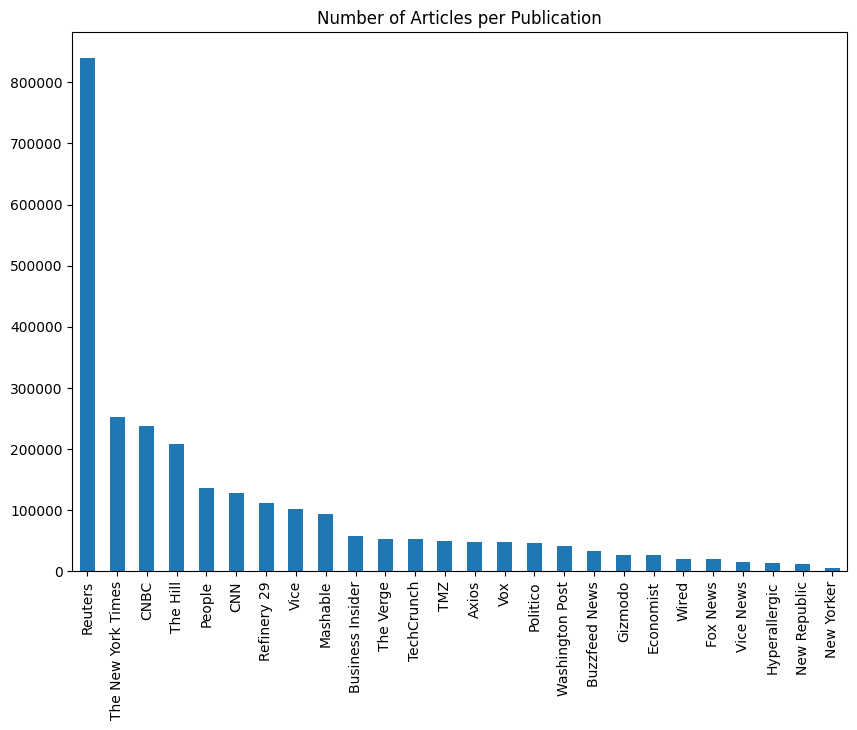

In [18]:
# Plot a simple bar chart of the number of articles per publication

df.publication.value_counts().plot(kind='bar', figsize=(10,7), title="Number of Articles per Publication")

The data is now loaded into a Pandas dataframe and we can see that Reuters accounts for a vast majority of the data. I'm unfamiliar with Refinery 29 and Hyperallergic. GLG states they are interested in the identification of topics that imply `technological` or `healthcare` terms, so Hyperallergic may yield useful results. 

One more check before we dive into the EDA. Let's see the distribution of years and most popular values in the `section` column.

<AxesSubplot: title={'center': 'Number of Articles Created per Year'}>

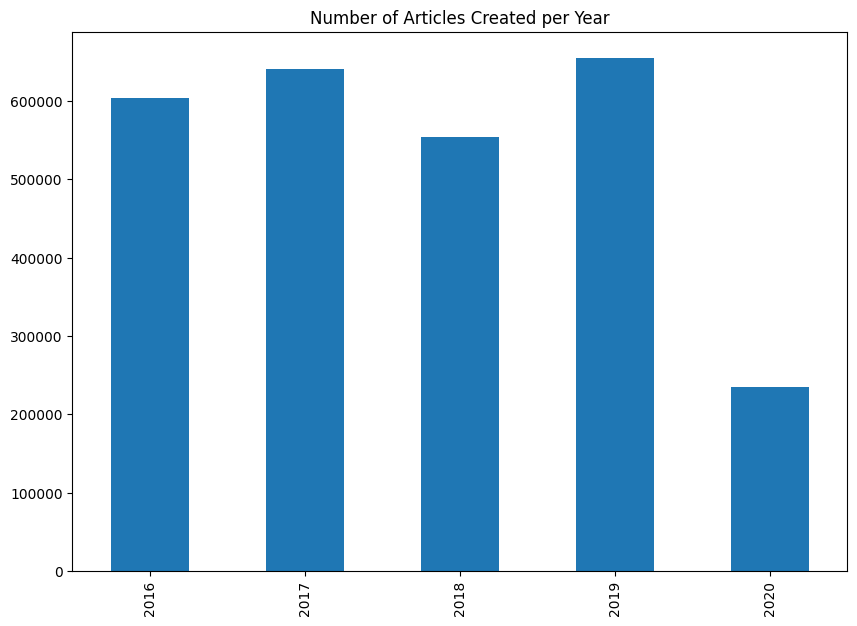

In [19]:
# Another simple bar chart of the number of articles per year

df.year.value_counts().sort_index(axis=0).plot(kind='bar', figsize=(10,7), title = 'Number of Articles Created per Year')

<AxesSubplot: title={'center': 'Top 20 Article Sections'}>

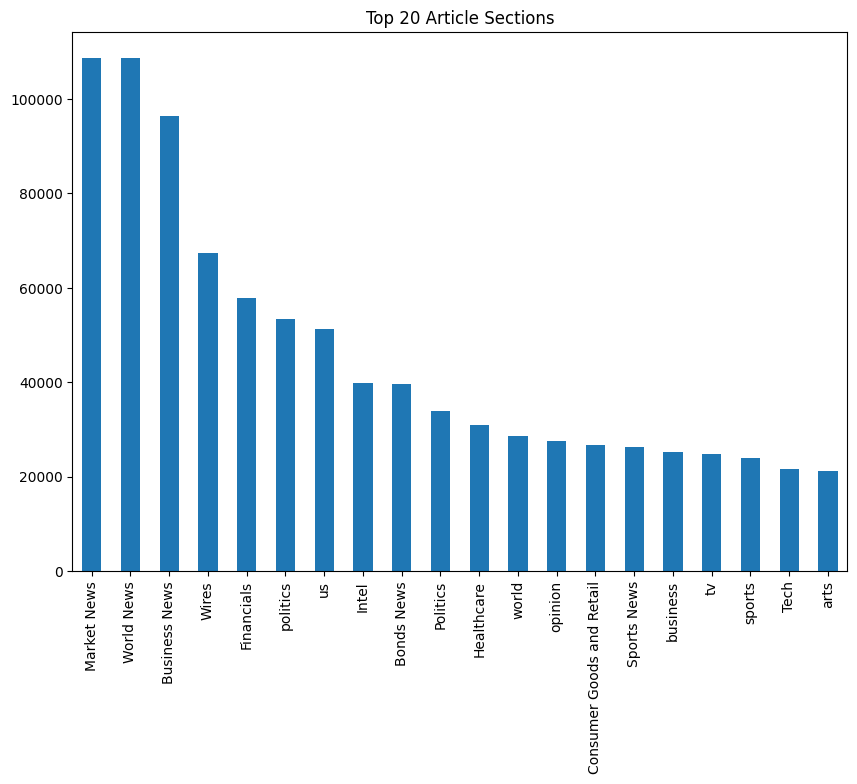

In [20]:
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Top 20 Article Sections')

<AxesSubplot: title={'center': 'Number of Articles Created per Month'}>

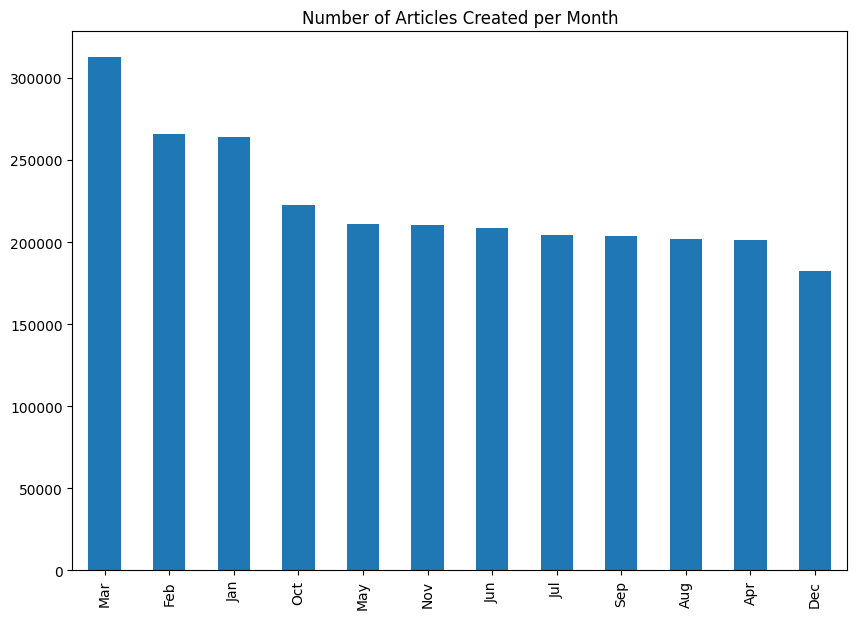

In [21]:
# Plot a simple bar chart of the most popular months for articles

df.month.value_counts().plot(kind='bar', figsize=(10,7), title='Number of Articles Created per Month')

A large amount of the articles are already classified as `technology` and `healthcare`. From 10,000 feet, it appears this dataset  will provide us several options for usage.

Now, we need to define our strategy for splitting our training and test set, and what additional analysis we want to perform to better understand our data.

### EDA Part 1: Data Preparation

The problem we still face is that our dataframe is 2.7M rows and heavy with `string` data. This next phase of exploring the data should consist of analyzing text statistics in the article columns (word and sentence count, word frequency, sentence length, average word length, etc.). 

To perform text analysis, we will use a combination of [Spacy](https://spacy.io/) and [NLTK](https://www.nltk.org/). Using these libraries effectively (i.e., with performance at the forefront) may require reducing the amount of data we're working with.

As mentioned previously, we can drop a few irrelevant columns (`author`, `title`, `url`). We will also drop all rows that do not have text in the `article` column. This will squeeze out even more memory. Next, we can split our dataset into a training and test set, just to be sure that we're not leaking any data for future modeling tasks. This may save even more memory.

Another approach is to sample our training set to pull out a sample dataset for analysis. There is enough data to make this quite easy to do.


In [22]:
# Check the allocation of memory for the dataframe

df.memory_usage(index=False)

date           21511024
year           21511024
month          21511024
day            21511024
author         21511024
title          21511024
article        21511024
url            21511024
section        21511024
publication    21511024
dtype: int64

In [23]:
# Drop the columns we don't need and create a new dataframe

drop_cols = [ 'url', 'author', 'title']
df_v1 = df.drop(drop_cols, axis=1)
df_v1.shape

(2688878, 7)

In [24]:
# Check the memory usage of the new dataframe

df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688878 entries, 0 to 2688877
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   year         int64         
 2   month        object        
 3   day          int64         
 4   article      object        
 5   section      object        
 6   publication  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 143.6+ MB


The new dataframe is smaller by about ~60 MB. 

In [25]:
# Let's take another look at the missing values

df_v1.isnull().sum()

date                0
year                0
month               0
day                 0
article        104713
section        912273
publication     12577
dtype: int64

In [26]:
# Drop the rows where article is missing

df_v1 = df_v1.dropna(subset=['article'])

In [27]:
df_v1.shape

(2584165, 7)

In [28]:
df_v1['article'].isnull().sum()

0

In [29]:
# Let's load scikit-learn and split the data into training and test sets. 

from sklearn.model_selection import train_test_split

train, test = train_test_split(df_v1, test_size=0.2, random_state=42)

In [30]:
train.shape

(2067332, 7)

In [31]:
# We'll use a 5% sample of the training set for purposes of text analytics and EDA

eda_train = train.sample(frac=.05, random_state=42)
eda_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103367 entries, 865261 to 565643
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         103367 non-null  datetime64[ns]
 1   year         103367 non-null  int64         
 2   month        103367 non-null  object        
 3   day          103367 non-null  int64         
 4   article      103367 non-null  object        
 5   section      70208 non-null   object        
 6   publication  103367 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 6.3+ MB


In [32]:
eda_train.shape

(103367, 7)

In [33]:
# Save a copy of the eda_train dataframe to a csv file in case of future kernel crashes

eda_train.to_csv('./data/eda_train.csv', index=False)

<AxesSubplot: >

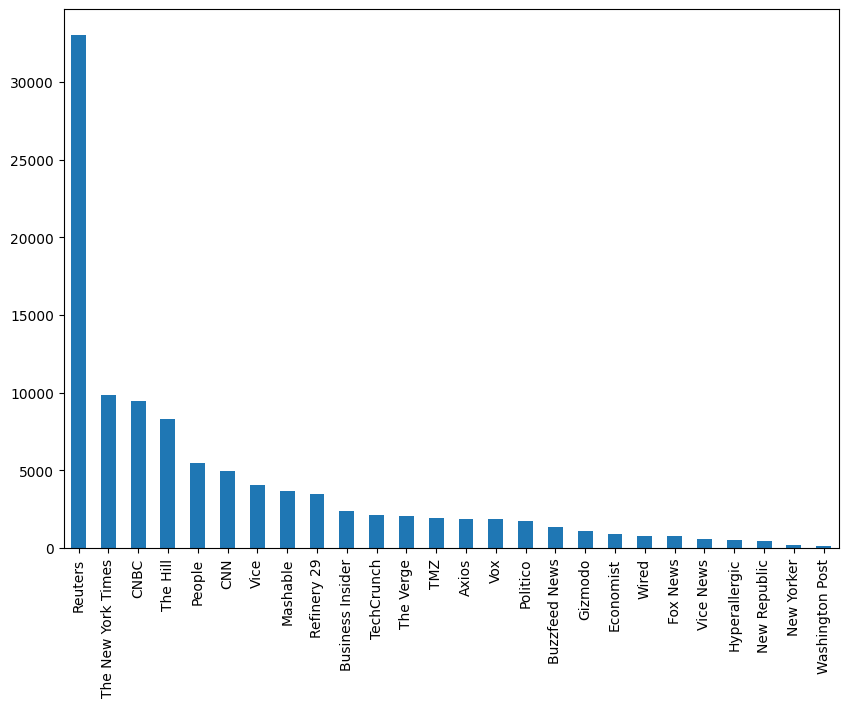

In [34]:
# Run the same plots on the new sample to check the distribution of articles, years and sections

eda_train.publication.value_counts().plot(kind='bar', figsize=(10,7))

<AxesSubplot: >

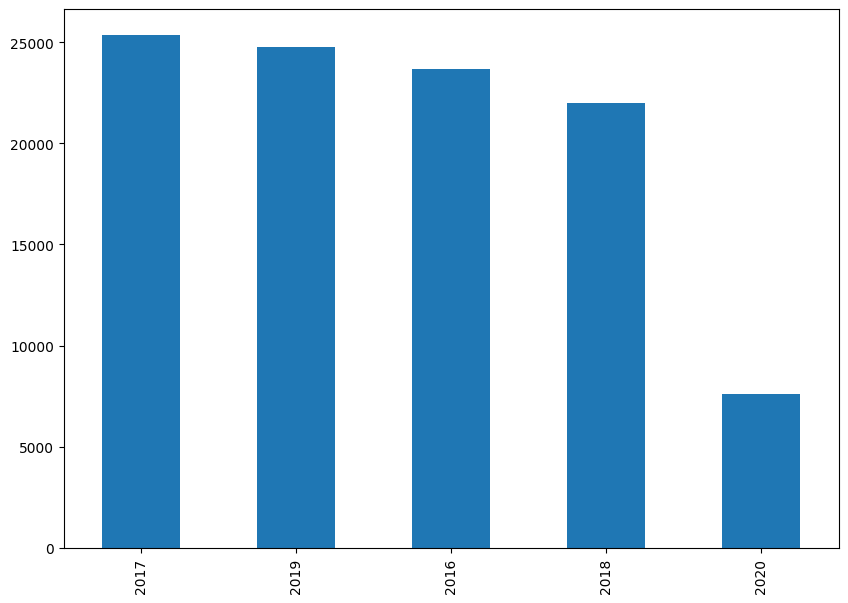

In [35]:
eda_train.year.value_counts().plot(kind='bar', figsize=(10,7))

<AxesSubplot: >

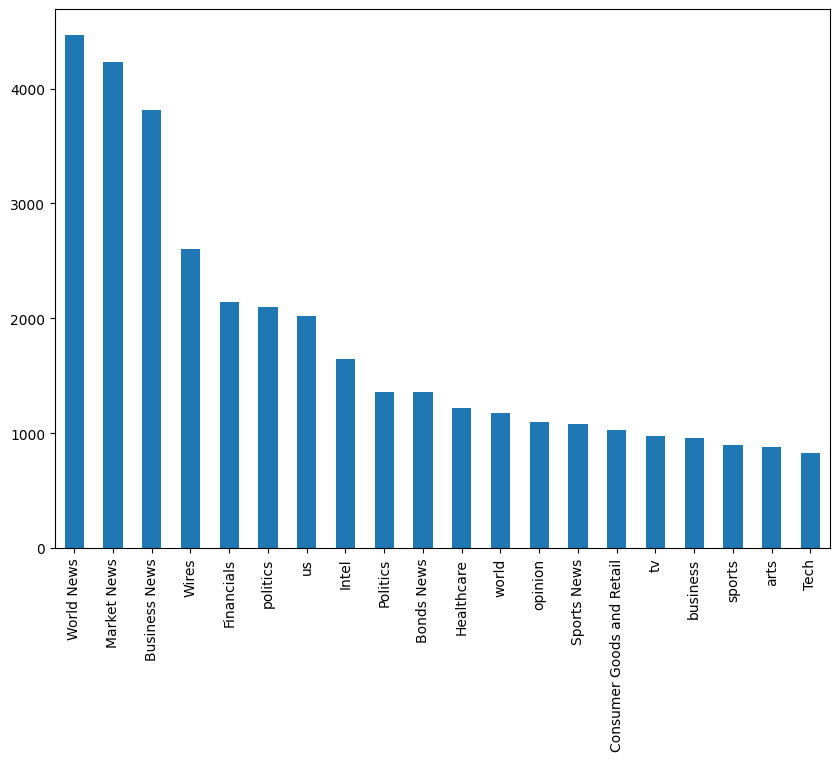

In [36]:
# Check the distribution of sections

eda_train['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7))

<AxesSubplot: title={'center': 'Number of Articles Created per Month'}>

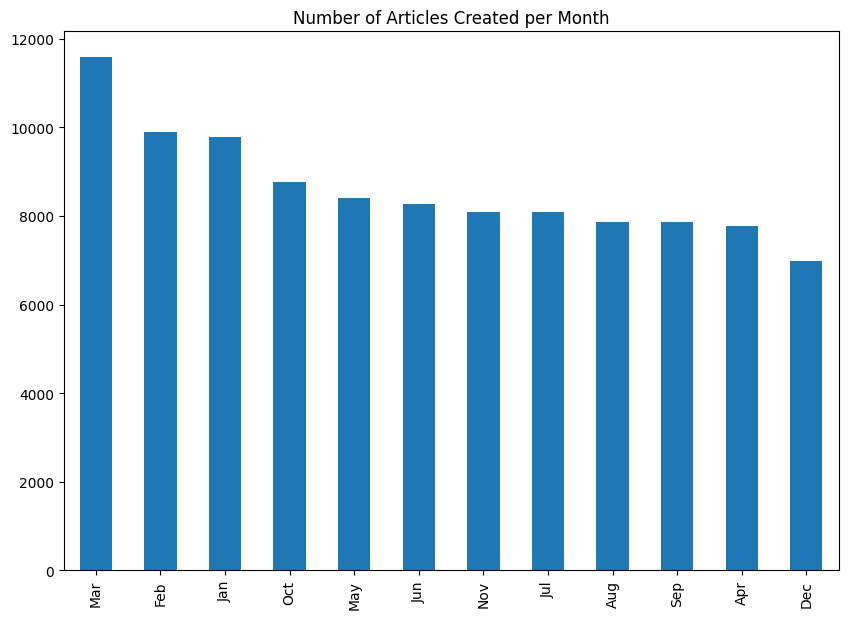

In [37]:
eda_train.month.value_counts().plot(kind='bar', figsize=(10,7), title='Number of Articles Created per Month')

The sample size of 103K rows appears to be a good representation of the original data distribution.

In this first step of EDA, we've:
1. Analyzed the memory usage of the full dataframe
2. Dropped three columns and created a new dataframe with the remaining seven columns
3. Dropped all rows where `article` data was missing.
4. Split our new dataframe into a training and test set
5. Took a sample of the training set and created a dataframe for analyzing text statistics

We will now see if our new dataset of 103K rows gives us the ability to run further text analysis.

### EDA Part 2: Text Analysis

In [38]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [39]:
# Load eda_train into a dataframe
eda_train = pd.read_csv('./data/eda_train.csv')
eda_train.head()

,date,year,month,day,article,section,publication
0,2017-11-27 00:00:00,2017,Nov,27,Nov 27 (Reuters) - Scout24 Ag: * BLOCK TRADE -...,IT Services & Consulting,Reuters
1,2018-08-11 00:00:00,2018,Aug,11,Maryland has placed members of the football su...,Sports News,Reuters
2,2019-04-11 00:00:00,2019,Apr,11,UBER SAYS CORE PLATFORM ADJUSTED NET REVENUE W...,Wires,CNBC
3,2018-09-28 00:00:00,2018,Sep,28,NEW DELHI (Reuters) - India’s burgeoning shado...,Business News,Reuters
4,2017-02-06 00:00:00,2017,Feb,6,Feb 6 (Reuters) - China Child Care Corporation...,Chinese Labor Unrest,Reuters


In [40]:
# Count the number of words in each article

eda_train['word_count'] = eda_train['article'].apply(lambda x: len(str(x).split(" ")))

In [41]:
# Count the number of characters in each article except spaces

eda_train['char_count'] = eda_train['article'].str.len() - eda_train['article'].str.count(" ")

In [42]:
eda_train.head()

,date,year,month,day,article,section,publication,word_count,char_count
0,2017-11-27 00:00:00,2017,Nov,27,Nov 27 (Reuters) - Scout24 Ag: * BLOCK TRADE -...,IT Services & Consulting,Reuters,35,171
1,2018-08-11 00:00:00,2018,Aug,11,Maryland has placed members of the football su...,Sports News,Reuters,498,2593
2,2019-04-11 00:00:00,2019,Apr,11,UBER SAYS CORE PLATFORM ADJUSTED NET REVENUE W...,Wires,CNBC,19,86
3,2018-09-28 00:00:00,2018,Sep,28,NEW DELHI (Reuters) - India’s burgeoning shado...,Business News,Reuters,1014,5294
4,2017-02-06 00:00:00,2017,Feb,6,Feb 6 (Reuters) - China Child Care Corporation...,Chinese Labor Unrest,Reuters,53,300


In [49]:
# Find one article with less than 50 characters to check the data

eda_train[eda_train['char_count'] < 50]

,date,year,month,day,article,section,publication,word_count,char_count
156,2017-08-01 00:00:00,2017,Aug,1,Credit Cheney Orr,in-puerto-rico-love-lingers-for-a-deserted-school,The New York Times,3,15
833,2017-06-27 00:00:00,2017,Jun,27,WATCH: More from Smarter Faster,NaN,Axios,5,27
1002,2016-03-21 00:00:00,2016,Mar,21,Credit Cheney Orr,christian-rodriguez-mexico-sierra-madre,The New York Times,3,15
2271,2016-05-11 00:00:00,2016,May,11,Oops Looks like your browser doesn't support J...,NaN,Buzzfeed News,8,49
2338,2016-09-27 00:00:00,2016,Sep,27,Oops Looks like your browser doesn't support J...,NaN,Buzzfeed News,8,49
...,...,...,...,...,...,...,...,...,...
101129,2018-11-11 00:00:00,2018,Nov,11,Oops Looks like your browser doesn't support J...,NaN,Buzzfeed News,8,49
101176,2016-06-09 00:00:00,2016,Jun,9,Credit Cheney Orr,emerging-young-photographers-in-the-south-bronx,The New York Times,3,15
102308,2017-08-24 20:03:00,2017,Aug,24,Check out Benny Montero's Instagram and Faceb...,Comics!,Vice,8,43
102610,2017-08-11 00:00:00,2017,Aug,11,Oops Looks like your browser doesn't support J...,NaN,Buzzfeed News,8,49


In [46]:
print(eda_train['article'][156])

Credit Cheney Orr


In [51]:
# Review the fourth article to check the data

print(eda_train['article'][3])

NEW DELHI (Reuters) - India’s burgeoning shadow finance sector is likely to face a shake-up after defaults at one major lender battered the nation’s financial markets in the past week and reinforced worries about credit risk. Industry officials and experts say they expect Indian regulators to cancel the licenses of as many as 1,500 smaller non-banking finance companies because they don’t have adequate capital, and to also make it more difficult for new applicants to get approval. The Reserve Bank of India (RBI), which has been tightening rules for non-banking financial companies (NBFCs), did not respond to requests for comment. Better capitalized and more conservatively run finance firms are likely to swallow up an increasing number of smaller rivals, the experts said. That could make it difficult for many small borrowers to get loans, especially in the countryside where two-thirds of India’s 1.3 billion people live, and put the brakes on a surge in private consumption with a knock-on 

<AxesSubplot: title={'center': 'Average Word Count per Publication'}, xlabel='publication'>

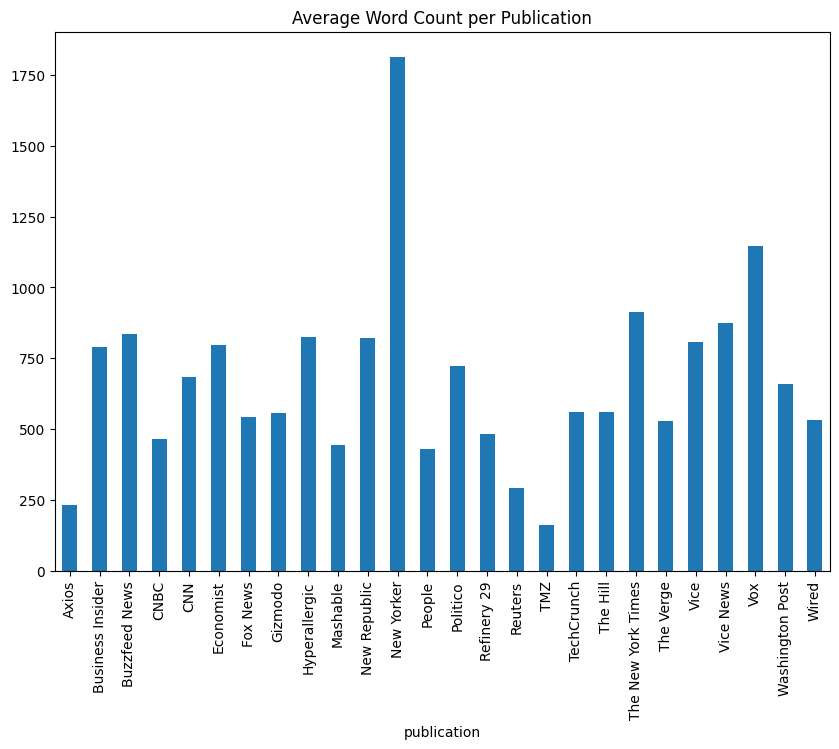

In [67]:
# Show the average word count for each publication

eda_train.groupby('publication')['word_count'].mean().plot(kind='bar', figsize=(10,7), title='Average Word Count per Publication')


The New Yorker magazine has the larget average word count, which isn't a surprise. We may want to considere dropping publications with lower word counts, such as TMZ.

Next, we'll count the number of sentences in each article. We will need to use a more power NLP tool to identify sentence boundries to provide an accurate count.

#### Count sentences

In [53]:
# Use Spacy to count the nuber of sentences in each article

text = eda_train['article']
eda_train['sentence_count'] = [len(list(doc.sents)) for doc in nlp.pipe(text.astype(str), disable=['ner', 'pos'])]

In [54]:
eda_train.head()

,date,year,month,day,article,section,publication,word_count,char_count,sentence_count
0,2017-11-27 00:00:00,2017,Nov,27,Nov 27 (Reuters) - Scout24 Ag: * BLOCK TRADE -...,IT Services & Consulting,Reuters,35,171,2
1,2018-08-11 00:00:00,2018,Aug,11,Maryland has placed members of the football su...,Sports News,Reuters,498,2593,25
2,2019-04-11 00:00:00,2019,Apr,11,UBER SAYS CORE PLATFORM ADJUSTED NET REVENUE W...,Wires,CNBC,19,86,1
3,2018-09-28 00:00:00,2018,Sep,28,NEW DELHI (Reuters) - India’s burgeoning shado...,Business News,Reuters,1014,5294,38
4,2017-02-06 00:00:00,2017,Feb,6,Feb 6 (Reuters) - China Child Care Corporation...,Chinese Labor Unrest,Reuters,53,300,5


It took almost 45 minutes to count the number of sentences in 103K articles. There is likely a better way to write this code for improved performance, such as disabling `parser` and enabling `senter`. For now, we'll go with what we have. A quick check of a few articles shows that the Spacy sentence count is reflective of the actual number of sentences in each article.

In [58]:
# Check the data for the fifth article. Does it have 25 sentences? Yes.

print(eda_train['article'][1])

Maryland has placed members of the football support staff on paid administrative leave as the investigation continues into the death of redshirt freshman Jordan McNair, the university announced Friday. A Maryland spokesperson would not name the people who were placed on leave. McNair, the Maryland offensive lineman who died after collapsing during a spring workout, had a body temperature of 106 degrees when taken to a local hospital in May, according to a report from ESPN on Friday. McNair, 19, also struggled to stand straight while running short sprints before his collapse, according to the report. While an official cause of death has not been released, ESPN reported sources said his death was due to heatstroke. The website of a foundation his family started in his memory also says McNair died of heatstroke. He collapsed on May 29 during the outdoor workout and died June 13. The university has hired a former collegiate athletic trainer, Dr. Rod Walters, to investigate whether coaches 

In [61]:
# Check the data on the fifth article. Does it have 5 sentences? No.

print(eda_train['article'][4])

Feb 6 (Reuters) - China Child Care Corporation Ltd * Discloseable Transaction Acquisition Of Convertible Notes * Company and Ever Smart Capital entered into sale and purchase agreement * Company has agreed to acquire convertible notes at a consideration equivalent to principal amount of hk$58.5 million Source text for Eikon: Further company coverage:


The quality of sentence count seems to peform better on more structured articles (i.e., longer text). Sentence count could be another feature we use in the future to target higher-quality articles for NER, topic clustering, and temporal analysis.

In [62]:
# Save the dataframe to a csv file in case of future kernel crashes

eda_train.to_csv('./data/eda_train_sentence_count.csv', index=False)

Text(0.5, 1.0, 'Number of sentences per article')

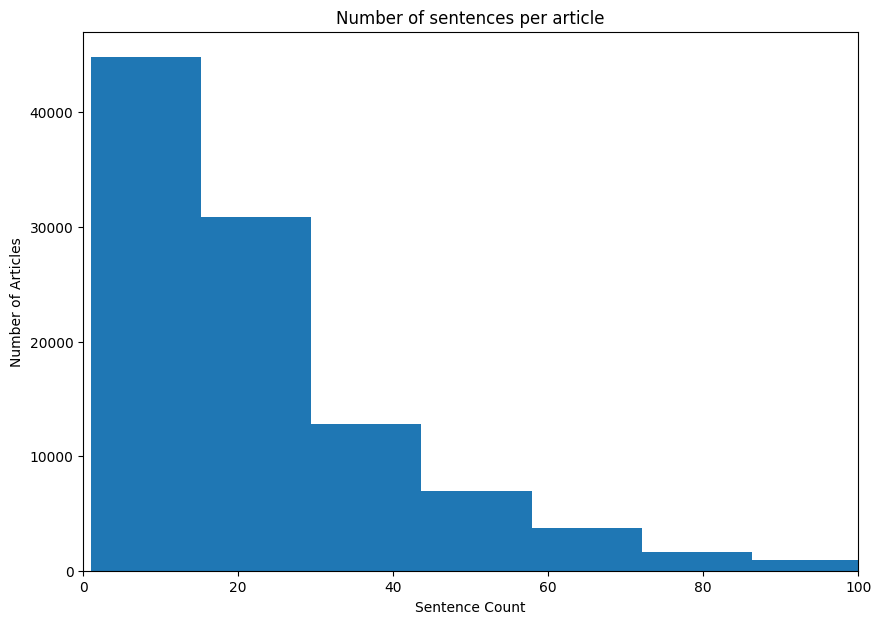

In [63]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(eda_train['sentence_count'], bins=150)
xlab = ax.set_xlabel('Sentence Count')
ylab = ax.set_ylabel('Number of Articles')
xlim = ax.set_xlim(0, 100)
ax.set_title('Number of sentences per article')

The majority of articles (70K+) have an average sentence length of 20 or fewer sentences. We can target a body of articles where the sentence count is ~ 20 sentences in future processing on the entire corpus (2.7M articles).

In [66]:
# Avg number of words per sentence

eda_train['avg_words_per_sentence'] = round(eda_train['word_count'] / eda_train['sentence_count'], 1)
eda_train.head()

,date,year,month,day,article,section,publication,word_count,char_count,sentence_count,avg_words_per_sentence
0,2017-11-27 00:00:00,2017,Nov,27,Nov 27 (Reuters) - Scout24 Ag: * BLOCK TRADE -...,IT Services & Consulting,Reuters,35,171,2,17.5
1,2018-08-11 00:00:00,2018,Aug,11,Maryland has placed members of the football su...,Sports News,Reuters,498,2593,25,19.9
2,2019-04-11 00:00:00,2019,Apr,11,UBER SAYS CORE PLATFORM ADJUSTED NET REVENUE W...,Wires,CNBC,19,86,1,19.0
3,2018-09-28 00:00:00,2018,Sep,28,NEW DELHI (Reuters) - India’s burgeoning shado...,Business News,Reuters,1014,5294,38,26.7
4,2017-02-06 00:00:00,2017,Feb,6,Feb 6 (Reuters) - China Child Care Corporation...,Chinese Labor Unrest,Reuters,53,300,5,10.6


We create another feature, avg_words_per_sentence, in case it helps with targetting certain articles for usage in the future.

In [95]:
# Avg word count per article
avg_word_count = round(eda_train['word_count'].mean(), 2)
print(f'The average number of words per article is {avg_word_count}')

The average number of words per article is 496.31


In [73]:
# Avg number of words per article per publication
eda_train.groupby('publication')['word_count'].mean().round(1)

publication
Axios                  232.3
Business Insider       788.7
Buzzfeed News          834.6
CNBC                   466.0
CNN                    685.1
Economist              796.8
Fox News               542.4
Gizmodo                556.1
Hyperallergic          825.9
Mashable               444.5
New Republic           822.3
New Yorker            1812.9
People                 431.1
Politico               724.1
Refinery 29            483.4
Reuters                291.1
TMZ                    160.1
TechCrunch             558.4
The Hill               560.0
The New York Times     911.9
The Verge              527.5
Vice                   807.0
Vice News              876.0
Vox                   1147.6
Washington Post        657.4
Wired                  533.4
Name: word_count, dtype: float64

#### Remove stop words

We will remove stop words, perform tokenization, and then identify some entities using Spacy's NER model.

In [74]:
# Use NLTK to remove stopwords

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
eda_train['clean_article'] =  eda_train['article'].astype(str).apply \
        (lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [75]:
# Check a long article to see if the stopwords have been removed

print(eda_train['clean_article'][1])

Maryland placed members football support staff paid administrative leave investigation continues death redshirt freshman Jordan McNair, university announced Friday. A Maryland spokesperson would name people placed leave. McNair, Maryland offensive lineman died collapsing spring workout, body temperature 106 degrees taken local hospital May, according report ESPN Friday. McNair, 19, also struggled stand straight running short sprints collapse, according report. While official cause death released, ESPN reported sources said death due heatstroke. The website foundation family started memory also says McNair died heatstroke. He collapsed May 29 outdoor workout died June 13. The university hired former collegiate athletic trainer, Dr. Rod Walters, investigate whether coaches team staff followed proper procedures became clear McNair struggling. It expected Walters’ report released mid-September. His family also hired legal team investigate death. ESPN talked multiple people described practi

Words such as "the", "is", "of", "and" etc. have been removed. We'll now create a tokenized list of each article, using the `clean_article` column we just created. Using Spacy NLP tokenizes the text by default, but we'll keep a raw list of tokens in case we want to use them for future analysis.

In [76]:
# Tokenize clean_article with NLTK
from nltk.tokenize import word_tokenize
nltk.download('punkt')

eda_train['raw_tokens'] = eda_train['clean_article'].map(lambda x: nltk.word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [77]:
eda_train.head()

,date,year,month,day,article,section,publication,word_count,char_count,sentence_count,avg_words_per_sentence,clean_article,raw_tokens
0,2017-11-27 00:00:00,2017,Nov,27,Nov 27 (Reuters) - Scout24 Ag: * BLOCK TRADE -...,IT Services & Consulting,Reuters,35,171,2,17.5,Nov 27 (Reuters) - Scout24 Ag: * BLOCK TRADE -...,"[Nov, 27, (, Reuters, ), -, Scout24, Ag, :, *,..."
1,2018-08-11 00:00:00,2018,Aug,11,Maryland has placed members of the football su...,Sports News,Reuters,498,2593,25,19.9,Maryland placed members football support staff...,"[Maryland, placed, members, football, support,..."
2,2019-04-11 00:00:00,2019,Apr,11,UBER SAYS CORE PLATFORM ADJUSTED NET REVENUE W...,Wires,CNBC,19,86,1,19.0,UBER SAYS CORE PLATFORM ADJUSTED NET REVENUE W...,"[UBER, SAYS, CORE, PLATFORM, ADJUSTED, NET, RE..."
3,2018-09-28 00:00:00,2018,Sep,28,NEW DELHI (Reuters) - India’s burgeoning shado...,Business News,Reuters,1014,5294,38,26.7,NEW DELHI (Reuters) - India’s burgeoning shado...,"[NEW, DELHI, (, Reuters, ), -, India, ’, s, bu..."
4,2017-02-06 00:00:00,2017,Feb,6,Feb 6 (Reuters) - China Child Care Corporation...,Chinese Labor Unrest,Reuters,53,300,5,10.6,Feb 6 (Reuters) - China Child Care Corporation...,"[Feb, 6, (, Reuters, ), -, China, Child, Care,..."


Now we'll use Spacy's NER API to identify entities in a few articles. Spacy has a list of entities it can identify in its documentation. 

In [78]:
# Find NER in the first article using spacy

text = eda_train['clean_article'][1]
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

Maryland GPE
Jordan McNair PERSON
Friday DATE
Maryland GPE
McNair ORG
Maryland GPE
106 degrees QUANTITY
May DATE
ESPN ORG
Friday DATE
McNair ORG
19 DATE
ESPN ORG
McNair PERSON
May 29 DATE
June 13 DATE
Rod Walters PERSON
McNair PERSON
Walters ORG
mid-September DATE
ESPN ORG
McNair ORG
45 minutes TIME
approximately 5 p.m. TIME
McNair ORG
McNair ORG
one-hour TIME
McNair PERSON
Billy Murphy PERSON
ESPN ORG
106 CARDINAL
one hour TIME
EMT ORG
Murphy PERSON
Maryland GPE
one CARDINAL
around 5 p.m. day TIME
ESPN ORG
Terrapins ORG
DJ Durkin PERSON
Rick Court PERSON
two CARDINAL
Maryland GPE
Durkin Court ORG


Spacy has identified several entities in our example article, most of which are good quality. McNair comes back as a PERSON and an ORG. We can also visualize the entities in the article by using `displacy.`

In [88]:
# Use displacy to visualize entities in the first article

from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

In [84]:
# Create a dataframe of 1000 articles to use for NER

ner_train = eda_train.sample(n=1000, random_state=42)

In [85]:
# Extract the named entities from each article and count the number of each entity

ners = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

ners_small = ['PERSON', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'DATE', 'TIME']

ner_train['ner'] = ner_train['clean_article'].map(lambda desc: dict(Counter ([ent.label_ for ent in nlp(desc).ents])))

for ner in ners:
    ner_train[ner] = ner_train['ner'].map(lambda x: x.get(ner, 0))

In [90]:
# Group the named entities by publication

ner_train.groupby('publication')[ners].sum()

,PERSON,NORP,FAC,ORG,GPE,LOC,PRODUCT,EVENT,WORK_OF_ART,LAW,LANGUAGE,DATE,TIME,PERCENT,MONEY,QUANTITY,ORDINAL,CARDINAL
publication,,,,,,,,,,,,,,,,,,
Axios,52,19,0,145,51,7,13,3,3,1,0,82,9,15,12,9,7,26
Business Insider,184,52,7,358,177,13,23,4,20,0,0,184,18,7,81,16,43,124
Buzzfeed News,97,39,0,139,97,2,10,1,6,1,0,58,6,2,4,2,3,50
CNBC,610,172,4,1187,563,52,43,7,25,4,0,876,30,241,187,20,40,330
CNN,702,232,10,960,433,37,22,6,33,3,1,499,49,33,18,11,62,229
Economist,92,23,1,76,34,2,7,1,3,0,0,52,1,7,8,6,7,47
Fox News,56,16,1,52,53,6,1,0,3,0,0,45,2,0,2,2,8,22
Gizmodo,63,10,1,108,46,20,6,0,7,1,0,33,3,6,4,1,9,30
Hyperallergic,160,65,5,95,54,5,1,9,24,0,3,88,3,1,3,8,9,35


In [91]:
ner_train.groupby('publication')[ners_small].sum()

,PERSON,ORG,GPE,LOC,PRODUCT,EVENT,DATE,TIME
publication,,,,,,,,
Axios,52,145,51,7,13,3,82,9
Business Insider,184,358,177,13,23,4,184,18
Buzzfeed News,97,139,97,2,10,1,58,6
CNBC,610,1187,563,52,43,7,876,30
CNN,702,960,433,37,22,6,499,49
Economist,92,76,34,2,7,1,52,1
Fox News,56,52,53,6,1,0,45,2
Gizmodo,63,108,46,20,6,0,33,3
Hyperallergic,160,95,54,5,1,9,88,3


The output make sense on first glance. Mashable shows a high amount of PRODUCT mentions (likely reviews), and news organizations, such as The New York Times and Reuters, show a high amount of PEOPLE and DATES. 

We can see that a small sample of 1,000 articles is rich with entities. 

Overall, the articles we've looked at raise a number of questions:

1. Should we spend time on this data to prepare for building our model, or use for testing purposes after our model is built using the `ner` and `ner dataset`?
2. How can we speed up performance to process large amounts of unstructured data so that we have a robust pipleline to handle multiple use cases?
3. What's the best way to leverage Spacy (or Huggingface) to identify entities within the Technology and Healthcare space?
4. How can we customize existing enterprise-ready NLP tools like Huggingface or Spacy to meet the project goals? 